In [ ]:
import tensorflow_datasets as tfds
import tensorflow as tf

In [ ]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

In [ ]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete761D5W/imdb_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete761D5W/imdb_reviews-test.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0.incomplete761D5W/imdb_reviews-unsupervised.tfrecord


Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/subwords8k/1.0.0. Subsequent calls will reuse this data.


we use encoder that would convert the text to vector representation with size = 8185

In [ ]:
encoder = info.features['text'].encoder

In [ ]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


test of this encoder in simple sentence

In [ ]:
sample_string = 'Hi TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [1052, 7961, 6307, 2327, 4043, 2120, 7975]
The original string: "Hi TensorFlow."


In [ ]:
assert original_string == sample_string

In [ ]:
for index in encoded_string:
  print('{} ----> {}'.format(index, encoder.decode([index])))

1052 ----> Hi
7961 ---->  
6307 ----> Ten
2327 ----> sor
4043 ----> Fl
2120 ----> ow
7975 ----> .


Prepare the data for training

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

Create the model

Embeding ( similar words have same vector representation) make model generalize what it learn about a word to all similar words

bidirectional model , its parameters are updated using the gradientscomputed during bachpropagation through time( BPTT )

In [37]:
model0 = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [38]:
model0.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

Train the model

In [39]:
history0 = model0.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 776s 2s/step - loss: 0.6669 - accuracy: 0.5273 - val_loss: 0.5926 - val_accuracy: 0.5698
Epoch 2/10
391/391 [==============================] - 798s 2s/step - loss: 0.3720 - accuracy: 0.8364 - val_loss: 0.3628 - val_accuracy: 0.8375
Epoch 3/10
391/391 [==============================] - 803s 2s/step - loss: 0.2557 - accuracy: 0.9010 - val_loss: 0.3283 - val_accuracy: 0.8656
Epoch 4/10
391/391 [==============================] - 798s 2s/step - loss: 0.2197 - accuracy: 0.9193 - val_loss: 0.3484 - val_accuracy: 0.8656
Epoch 5/10
391/391 [==============================] - 793s 2s/step - loss: 0.1919 - accuracy: 0.9314 - val_loss: 0.3448 - val_accuracy: 0.8682
Epoch 6/10
391/391 [==============================] - 803s 2s/step - loss: 0.1716 - accuracy: 0.9397 - val_loss: 0.4139 - val_accuracy: 0.8521
Epoch 7/10
391/391 [==============================] - 795s 2s/step - loss: 0.1533 - accuracy: 0.9470 - val_loss: 0.3649 - val_accuracy: 0.8714

In [40]:
test_loss, test_acc = model0.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 168s 429ms/step - loss: 0.4018 - accuracy: 0.8576
Test Loss: 0.4018203914165497
Test Accuracy: 0.8575999736785889


In [41]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [42]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model0.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [43]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[0.26220542]]


In [44]:
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[0.318237]]


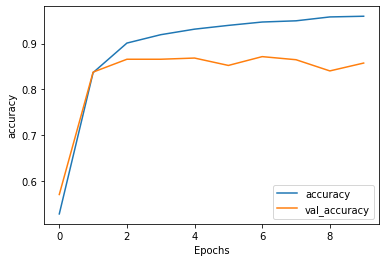

In [45]:
plot_graphs(history0, 'accuracy')

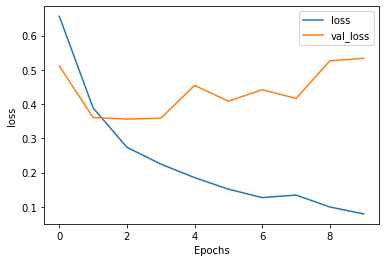

In [46]:
plot_graphs(history, 'loss')

Stack two or more LSTM layers

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [ ]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [25]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 1506s 4s/step - loss: 0.6565 - accuracy: 0.5544 - val_loss: 0.5114 - val_accuracy: 0.7776
Epoch 2/10
391/391 [==============================] - 1503s 4s/step - loss: 0.3887 - accuracy: 0.8366 - val_loss: 0.3608 - val_accuracy: 0.8521
Epoch 3/10
391/391 [==============================] - 1502s 4s/step - loss: 0.2737 - accuracy: 0.8998 - val_loss: 0.3562 - val_accuracy: 0.8604
Epoch 4/10
391/391 [==============================] - 1502s 4s/step - loss: 0.2248 - accuracy: 0.9228 - val_loss: 0.3584 - val_accuracy: 0.8667
Epoch 5/10
391/391 [==============================] - 1509s 4s/step - loss: 0.1852 - accuracy: 0.9395 - val_loss: 0.4546 - val_accuracy: 0.8526
Epoch 6/10
391/391 [==============================] - 1516s 4s/step - loss: 0.1514 - accuracy: 0.9545 - val_loss: 0.4085 - val_accuracy: 0.8500
Epoch 7/10
391/391 [==============================] - 1491s 4s/step - loss: 0.1269 - accuracy: 0.9644 - val_loss: 0.4419 - val_accuracy:

In [26]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 311s 794ms/step - loss: 0.5524 - accuracy: 0.8282
Test Loss: 0.552406907081604
Test Accuracy: 0.8281599879264832


In [ ]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [27]:
sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

[[-2.8456886]]


In [28]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

[[-4.1999836]]


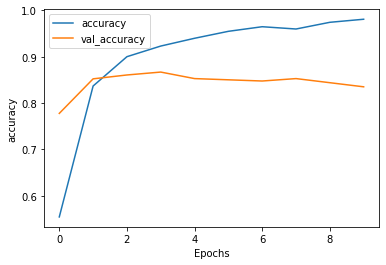

In [29]:
plot_graphs(history, 'accuracy')

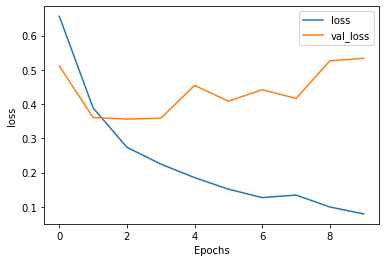

In [30]:
plot_graphs(history, 'loss')